# Utils

## libs

In [1]:
!pip install umap-learn
!pip install cleverhans
!pip install pytorch-metric-learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=53f5993051afc60c1c1fec375a2268958aa6b3afc10c39d27a4e04747e89cb6f
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=2a9375435de30632cda3a36e49ea045eb8a5b1883c67d771188c909e54e356fe
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/pu

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from tqdm import tqdm
import pandas as pd
from torch.optim.lr_scheduler import StepLR
from umap import UMAP
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)
from pytorch_metric_learning.losses import AngularLoss
plt.style.use('ggplot')

## performance plot

In [3]:
def plot_performance(history,name="Model"):
  figure, axis = plt.subplots(1, 2,figsize=(15,10))
  figure.suptitle('{} performance'.format(name), fontsize=16)
  axis[0].plot(history['epochs'],history['val_loss'])
  axis[0].plot(history['epochs'],history['train_loss'])
  axis[0].set_xticks(range(epochs))
  axis[0].set_xlabel("Epochs")
  axis[0].set_ylabel("Accuracy")
  axis[0].set_title("Loss")
  axis[1].plot(history['epochs'],history['val_acc'])
  axis[1].plot(history['epochs'],history['train_acc'])
  axis[1].set_xlabel("Epochs")
  axis[1].set_ylabel("Loss")
  axis[1].set_title("Accuracy")
  axis[1].set_xticks(range(epochs))
  figure.legend(["Val", "Train"], loc='upper right')
  figure.tight_layout(pad=5.0)
  return

## dataloader

In [4]:
def Dataloader(bs,split_ratio,transform,test_transform):
  trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
  testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

  # Split the training data into train and validation sets
  train_size = int(split_ratio * len(trainset))
  val_size = len(trainset) - train_size
  torch.manual_seed(0)
  trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

  # Create data loaders
  train_loader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=False, num_workers=2)
  val_loader = torch.utils.data.DataLoader(valset, batch_size=bs, shuffle=False, num_workers=2)
  test_loader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=2)
  return train_loader,val_loader,test_loader

## Meter


In [5]:
class AverageMeter(object):
    """
    computes and stores the average and current value
    """

    def __init__(self, start_val=0, start_count=0, start_avg=0, start_sum=0):
        self.reset()
        self.val = start_val
        self.avg = start_avg
        self.sum = start_sum
        self.count = start_count

    def reset(self):
        """
        Initialize 'value', 'sum', 'count', and 'avg' with 0.
        """
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, num=1):
        """
        Update 'value', 'sum', 'count', and 'avg'.
        """
        self.val = val
        self.sum += val * num
        self.count += num
        self.avg = self.sum / self.count


def save_model(file_path, file_name, model, optimizer=None):
    """
    In this function, a model is saved.Usually save model after training in each epoch.
    ------------------------------------------------
    Args:
        - model (torch.nn.Module)
        - optimizer (torch.optim)
        - file_path (str): Path(Folder) for saving the model
        - file_name (str): name of the model checkpoint to save
    """
    state_dict = dict()
    state_dict["model"] = model.state_dict()

    if optimizer is not None:
        state_dict["optimizer"] = optimizer.state_dict()
    torch.save(state_dict, os.path.join(file_path, file_name))


def load_model(ckpt_path, model, optimizer=None):
    """
    Loading a saved model and optimizer (from checkpoint)
    """
    checkpoint = torch.load(ckpt_path, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint["model"])
    if (optimizer != None) & ("optimizer" in checkpoint.keys()):
        optimizer.load_state_dict(checkpoint["optimizer"])
    return model, optimizer


def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            # correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            correct_k = correct[:k].float().sum()
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

# Resnet

In [6]:

class Resnet18:
  def __init__(self,num_classes,gamma,step_size,model_name,loss=None):
    self.num_classes=num_classes
    self.gamma=gamma
    self.step_size=step_size
    self.model_name=model_name
    self.model = resnet18(pretrained=False)
    self.model.fc = nn.Linear(self.model.fc.in_features, self.num_classes)
    self.model = self.model.to(device)
    # Define the loss function and optimizer
    self.criterion = loss
    self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
    self.lr_scheduler = StepLR(self.optimizer, step_size=self.step_size, gamma=self.gamma)
  def train(self,batch_size,epochs,learning_rate,ckpt_save_freq,report,ckpt_save_path,report_path,train_loader,val_loader):
    history={"val_acc":[],"train_acc":[],"val_loss":[],"train_loss":[],"epochs":[]}
    for epoch in tqdm(range(1, epochs + 1)):
        top1_acc_train = AverageMeter()
        loss_avg_train = AverageMeter()
        top1_acc_val = AverageMeter()
        loss_avg_val = AverageMeter()
        self.model.train()
        mode = "train"
        loop_train = tqdm(
            enumerate(train_loader, 1),
            total=len(train_loader),
            desc="train",
            position=0,
            leave=True)
        temp1=0
        temp2=0
        counter=0
        for batch_idx, (images, labels) in loop_train:
            images = images.to(device)
            labels = labels.to(device)
            labels_pred = self.model(images)
            loss = self.criterion(labels_pred, labels)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            acc1 = accuracy(labels_pred, labels)
            top1_acc_train.update(acc1[0], images.size(0))
            loss_avg_train.update(loss.item(), images.size(0))
            counter=counter+1
            temp1=temp1+loss_avg_train.avg
            temp2=temp2+top1_acc_train.avg
            new_row = pd.DataFrame(
                {"model_name": self.model_name,
                  "mode": mode,
                  "image_type":"original",
                  "epoch": epoch,
                  "learning_rate":self.optimizer.param_groups[0]["lr"],
                  "batch_size": images.size(0),
                  "batch_index": batch_idx,
                  "loss_batch": loss.detach().item(),
                  "avg_train_loss_till_current_batch":loss_avg_train.avg,
                  "avg_train_top1_acc_till_current_batch":top1_acc_train.avg,
                  "avg_val_loss_till_current_batch":None,
                  "avg_val_top1_acc_till_current_batch":None},index=[0])

            
            report.loc[len(report)] = new_row.values[0]
            
            loop_train.set_description(f"Train - iteration : {epoch}")
            loop_train.set_postfix(
                loss_batch="{:.4f}".format(loss.detach().item()),
                avg_train_loss_till_current_batch="{:.4f}".format(loss_avg_train.avg),
                top1_accuracy_train="{:.4f}".format(top1_acc_train.avg),
                max_len=2,
                refresh=True,
            )
        if epoch % ckpt_save_freq == 0:
            save_model(
                file_path=ckpt_save_path,
                file_name=f"ckpt_{self.model_name}_epoch{epoch}.ckpt",
                model=self.model,
                optimizer=self.optimizer,
            )
        history["train_loss"].append(temp1/counter)
        history["train_acc"].append(temp2/counter)
        self.model.eval()
        mode = "val"
        with torch.no_grad():
            loop_val = tqdm(
                enumerate(val_loader, 1),
                total=len(val_loader),
                desc="val",
                position=0,
                leave=True,
            )
            temp1=0
            temp2=0
            counter=0
            for batch_idx, (images, labels) in loop_val:
                self.optimizer.zero_grad()
                images = images.to(device).float()
                labels = labels.to(device)
                labels_pred = self.model(images)
                loss = self.criterion(labels_pred, labels)
                acc1 = accuracy(labels_pred, labels)
                top1_acc_val.update(acc1[0], images.size(0))
                loss_avg_val.update(loss.item(), images.size(0))
                temp1=loss_avg_val.avg+temp1
                temp2=top1_acc_val.avg+temp2
                counter=counter+1
                new_row = pd.DataFrame(
                    {"model_name": self.model_name,
                      "mode": mode,
                      "image_type":"original",
                      "epoch": epoch,
                      "learning_rate":self.optimizer.param_groups[0]["lr"],
                      "batch_size": images.size(0),
                      "batch_index": batch_idx,
                      "loss_batch": loss.detach().item(),
                      "avg_train_loss_till_current_batch":None,
                      "avg_train_top1_acc_till_current_batch":None,
                      "avg_val_loss_till_current_batch":loss_avg_val.avg,
                      "avg_val_top1_acc_till_current_batch":top1_acc_val.avg},index=[0],)
                
                report.loc[len(report)] = new_row.values[0]
                loop_val.set_description(f"val - iteration : {epoch}")
                loop_val.set_postfix(
                    loss_batch="{:.4f}".format(loss.detach().item()),
                    avg_val_loss_till_current_batch="{:.4f}".format(loss_avg_val.avg),
                    top1_accuracy_val="{:.4f}".format(top1_acc_val.avg),
                    refresh=True,
                )
        history["val_loss"].append(temp1/counter)
        history["val_acc"].append(temp2/counter)
        history["epochs"].append(epoch)
        self.lr_scheduler.step()
    report.to_csv(f"{report_path}/{self.model_name}_report.csv")
    return self.model,history
  def Backbone(self):
    self.backbone = nn.Sequential(*list(self.model.children())[:-1])
    classifier = nn.Sequential(self.model.fc)
    return self.backbone
  def evaluate(self,testloader,datatype="test"):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    self.model.eval()
    self.backbone.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device).float()
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = self.model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the {self.model_name} on the {total} {datatype} images: {100 * correct // total} %')
  def feature_extractor(self,testloader):
    features=[]
    self.model.eval()
    self.backbone.eval()
    for (images, labels) in testloader:
            images = images.to(device)
            labels = labels.to(device)
            labels_pred = self.backbone(images)
            features.extend(labels_pred.squeeze().tolist())
    return features

In [7]:
def labels_extract(train_loader):
  target_list = []
  for batch_idx, (data, targets) in enumerate(train_loader):
      # Collect the targets for the current batch
      target_list.extend(targets.tolist())
  return target_list

In [8]:
class Umap_model:
  def __init__(self,train_loader,test_loader,n_com=2):
    self.train_loader=train_loader
    self.test_loader=test_loader
    self.n_components=n_com
    self.reducer = UMAP(n_components=n_com)
    self.clean_train_features=None
    self.clean_test_features=None
    self.train_tags=labels_extract(self.train_loader)
    self.test_tags=labels_extract(self.test_loader)
    return 
  def fit_transform(self,model):
    self.model_name=model.model_name
    clean_train_features=model.feature_extractor(self.train_loader)
    clean_test_features=model.feature_extractor(self.test_loader)
    self.reducer.fit(clean_train_features)
    self.clean_train_features=self.reducer.transform(clean_train_features)
    self.clean_test_features=self.reducer.transform(clean_test_features)
    return 
  def plotter(self):
    figure, axis = plt.subplots(1, 2,figsize=(15,10))
    figure.suptitle('Umap representation for {}'.format(self.model_name), fontsize=16)
    scat=axis[0].scatter(self.clean_train_features[:,1],self.clean_train_features[:,0],c=self.train_tags,label=self.train_tags, cmap='tab10')
    figure.legend(handles=scat.legend_elements()[0], loc="lower left",labels=[0,1,2,3,4,5,6,7,8,9])
    scat=axis[1].scatter(self.clean_test_features[:,1],self.clean_test_features[:,0],c= self.test_tags,label= self.test_tags, cmap='tab10')
    plt.legend(handles=scat.legend_elements()[0], loc="lower left",labels=[0,1,2,3,4,5,6,7,8,9])
    return 

In [9]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

# 2

In [10]:
# Load the CIFAR10 dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233,0.24348505,0.26158768))
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader,val_loader,test_loader=Dataloader(256,0.2,transform,transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 67634890.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
# Define the ResNet18 model properties
num_classes = 10
step_size=10
gamma=0.5
batch_size = 64
epochs = 20
learning_rate = 1e-3
ckpt_save_freq = 10
report = pd.DataFrame(columns=["model_name","mode","image_type","epoch","learning_rate","batch_size",
                               "batch_index","loss_batch","avg_train_loss_till_current_batch","avg_train_top1_acc_till_current_batch",
                               "avg_val_loss_till_current_batch","avg_val_top1_acc_till_current_batch"])
ckpt_save_path="./"
report_path="./"

In [12]:
#define resnet
model_name="Resnet18_Without_Adv_training"
loss=nn.CrossEntropyLoss()
clean_resnet18=Resnet18(num_classes,gamma,step_size,model_name,loss)
clearn_model,history=clean_resnet18.train(batch_size,epochs,learning_rate,ckpt_save_freq,report,ckpt_save_path,report_path,train_loader,val_loader)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 20/20 [05:48<00:00, 17.43s/it]


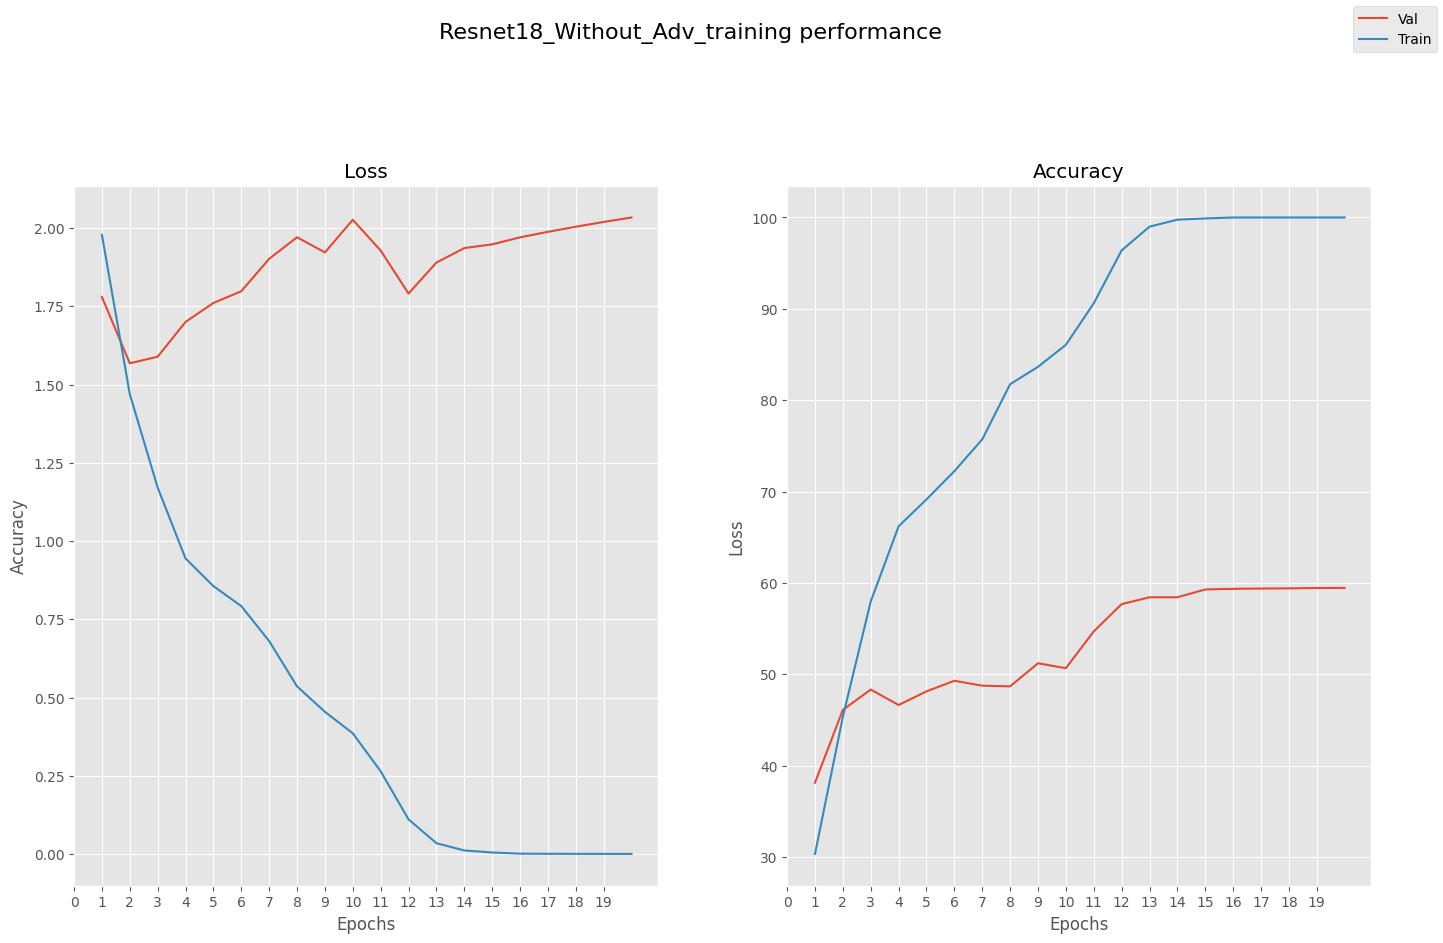

In [14]:
plot_performance(history,model_name)

In [15]:
clean_resnet18_backbone=clean_resnet18.Backbone()
clean_resnet18.evaluate(test_loader,"test")
clean_resnet18.evaluate(train_loader,"train")
clean_resnet18_backbone=clean_resnet18.Backbone()

Accuracy of the Resnet18_Without_Adv_training on the 10000 test images: 58 %
Accuracy of the Resnet18_Without_Adv_training on the 10000 train images: 100 %


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


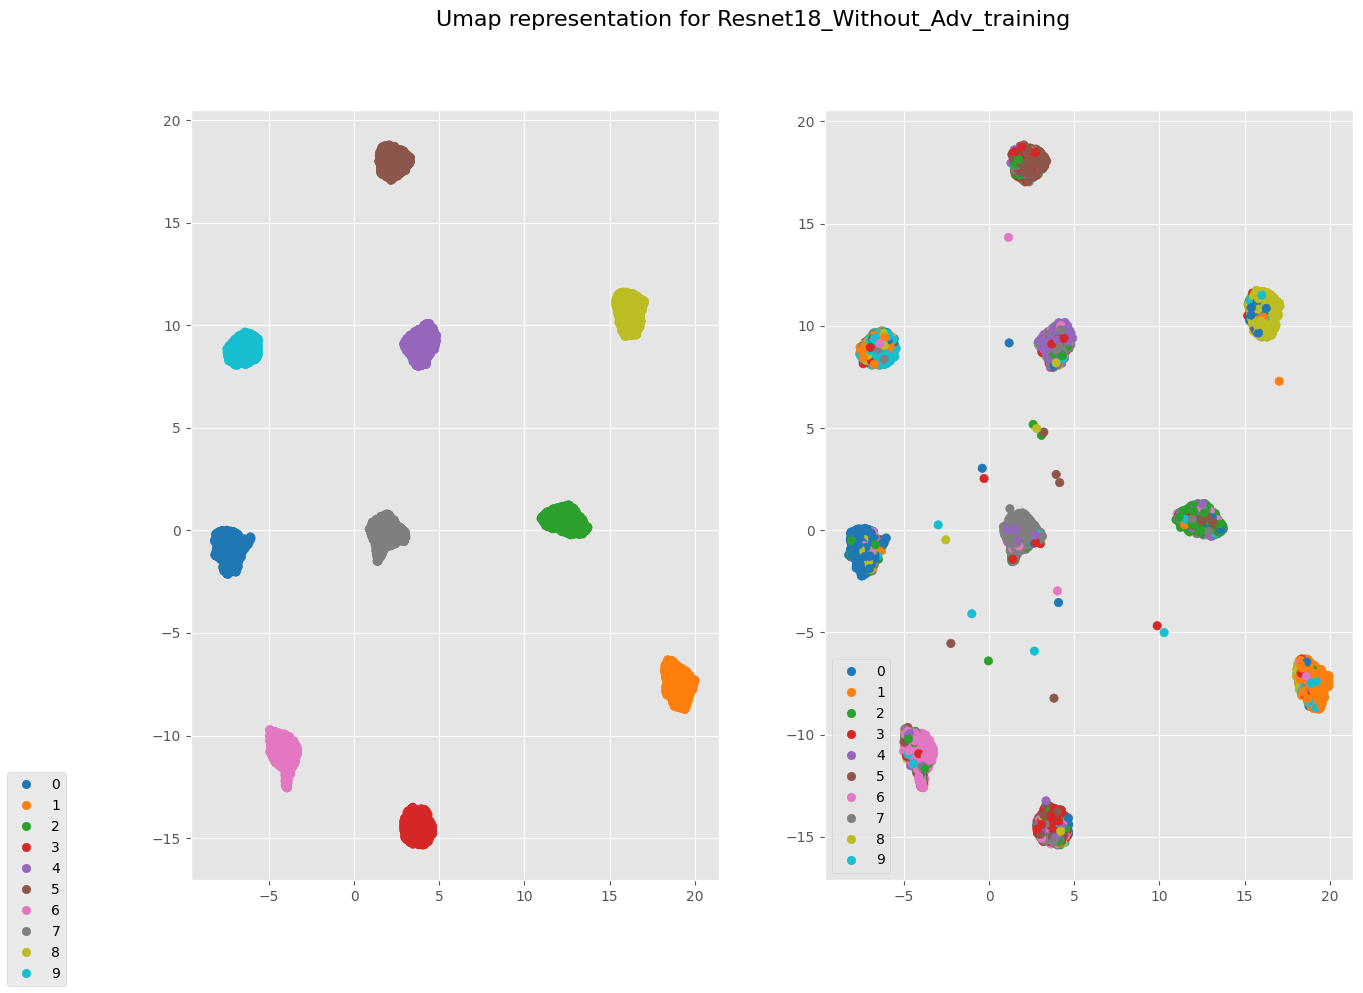

In [16]:
umap_rep=Umap_model(train_loader,test_loader,2)
umap_rep.fit_transform(clean_resnet18)
umap_rep.plotter()

# 3)

In [17]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233,0.24348505,0.26158768)),
    torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
    AddGaussianNoise(0., 1.),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.RandomHorizontalFlip(p=0.1)
])
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233,0.24348505,0.26158768))
])
train_loader,val_loader,test_loader=Dataloader(256,0.2,transform,test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
clean_resnet18.evaluate(test_loader,"test")
clean_resnet18.evaluate(train_loader,"train")


Accuracy of the Resnet18_Without_Adv_training on the 10000 test images: 34 %
Accuracy of the Resnet18_Without_Adv_training on the 10000 train images: 100 %


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


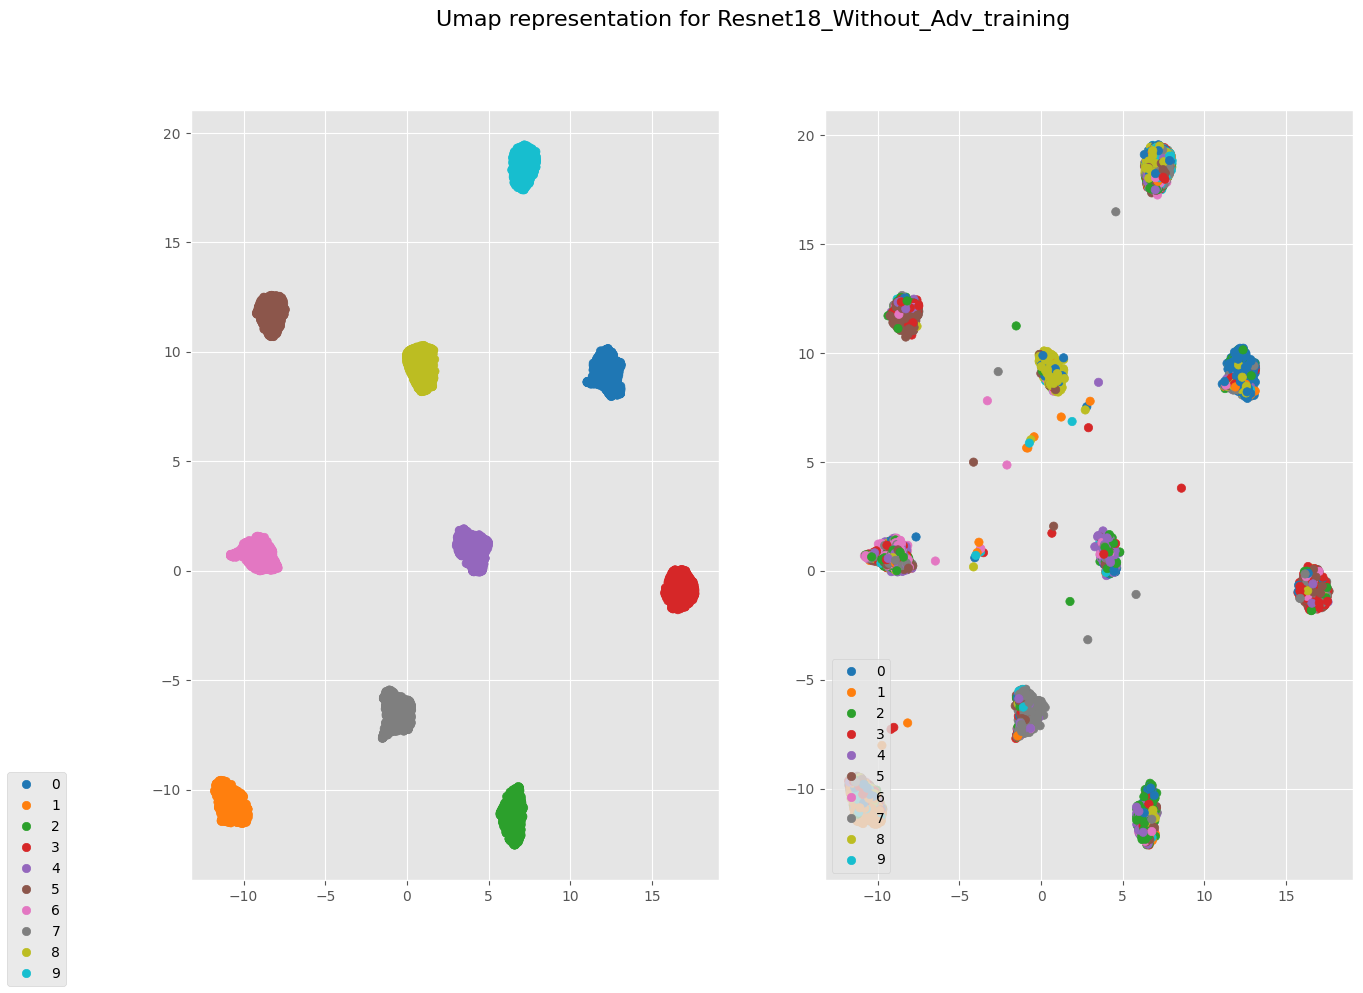

In [19]:
umap_rep=Umap_model(train_loader,test_loader,2)
umap_rep.fit_transform(clean_resnet18)
umap_rep.plotter()

## Fast gradient attack

In [21]:
correct = 0
total = 0
clearn_model.eval()
test_images_features=[]
clean_resnet18_backbone=clean_resnet18.Backbone()
for data in test_loader:
    images, labels = data
    images = images.to(device).float()
    labels = labels.to(device)
    # calculate outputs by running images through the network
    #torch.set_grad_enabled(True)
    images = fast_gradient_method(clearn_model, images, 0.3, np.inf)
    im=clean_resnet18_backbone(images)
    test_images_features.extend(im.squeeze().tolist())
    outputs = clearn_model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
correct = 0
total = 0
train_images_features=[]
for data in train_loader:
    images, labels = data
    images = images.to(device).float()
    labels = labels.to(device)
    # calculate outputs by running images through the network
    #torch.set_grad_enabled(True)
    images = fast_gradient_method(clearn_model, images, 0.3, np.inf)
    outputs = clearn_model(images)
    im=clean_resnet18_backbone(images)
    train_images_features.extend(im.squeeze().tolist())
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 40000 train images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 16 %
Accuracy of the network on the 40000 train images: 0 %


In [22]:
reducer = UMAP(n_components=2)
reducer.fit(train_images_features)
adv_train_features=reducer.transform(train_images_features)
adv_test_features=reducer.transform(test_images_features)

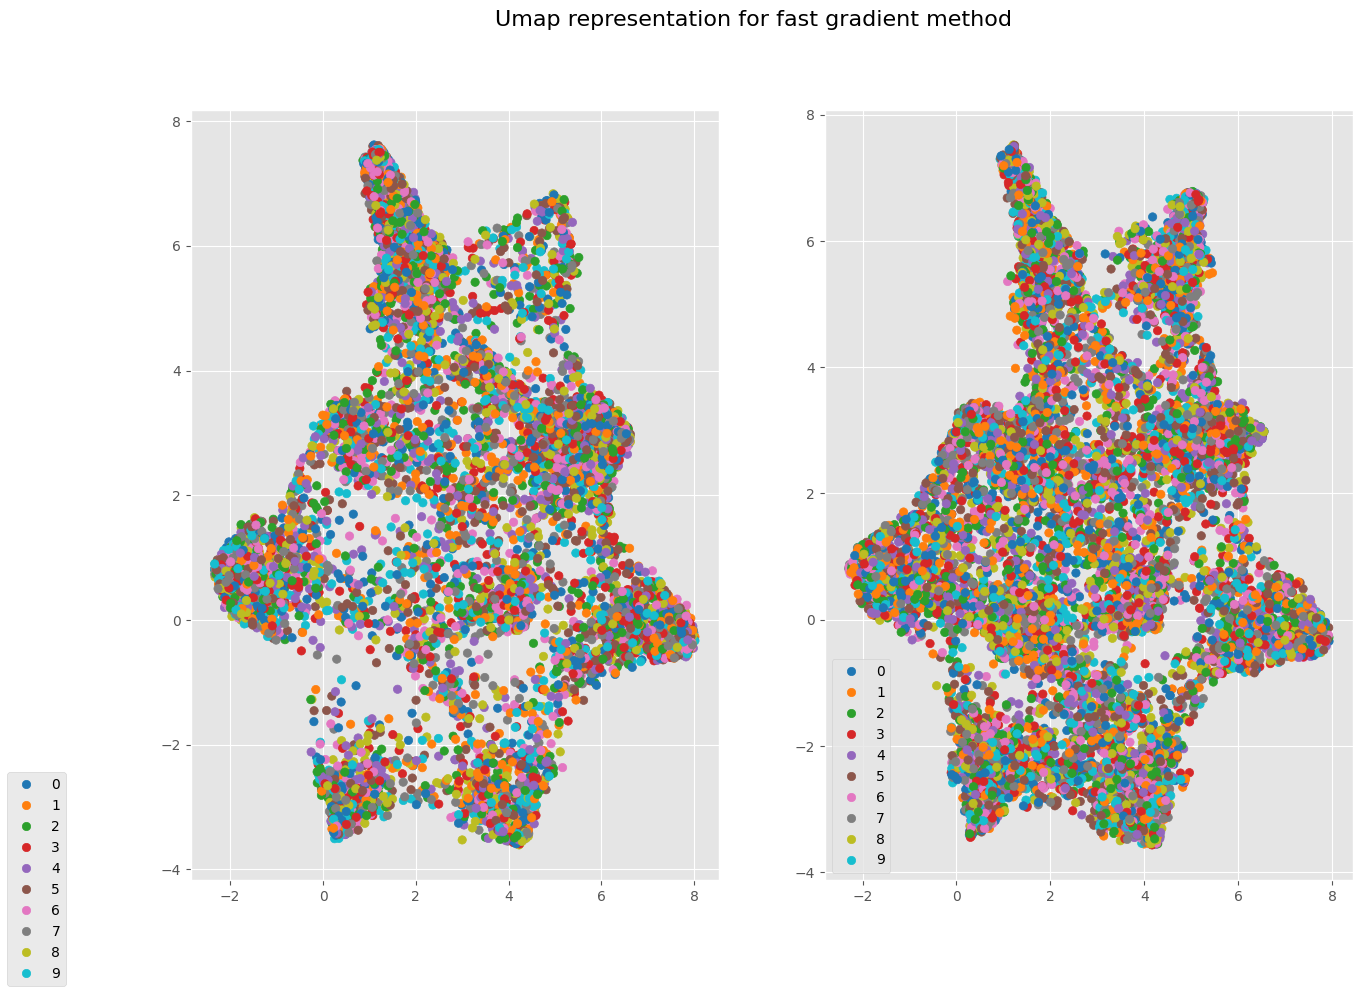

In [23]:
train_tags=labels_extract(train_loader)
test_tags=labels_extract(test_loader)
figure, axis = plt.subplots(1, 2,figsize=(15,10))
figure.suptitle('Umap representation for fast gradient method', fontsize=16)
scat=axis[0].scatter(adv_test_features[:,1],adv_test_features[:,0],c=train_tags,label=train_tags, cmap='tab10')
figure.legend(handles=scat.legend_elements()[0], loc="lower left",labels=[0,1,2,3,4,5,6,7,8,9])
scat=axis[1].scatter(adv_train_features[:,1],adv_train_features[:,0],c= test_tags,label= test_tags, cmap='tab10')
plt.legend(handles=scat.legend_elements()[0], loc="lower left",labels=[0,1,2,3,4,5,6,7,8,9])

# 4)

In [28]:
# Load the CIFAR10 dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
    AddGaussianNoise(0., 1.),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.RandomHorizontalFlip(p=0.1)
])
train_loader,val_loader,test_loader=Dataloader(256,0.8,transform,transform)

Files already downloaded and verified
Files already downloaded and verified


In [29]:
num_classes = 10
step_size=10
gamma=0.5
model_name="Resnet18_with_adv_training"
loss=nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_adv=Resnet18(num_classes,gamma,step_size,model_name,loss)

batch_size = 64
epochs = 20
learning_rate = 1e-3
ckpt_save_freq = 10

report = pd.DataFrame(columns=["model_name","mode","image_type","epoch","learning_rate","batch_size",
                               "batch_index","loss_batch","avg_train_loss_till_current_batch","avg_train_top1_acc_till_current_batch",
                               "avg_val_loss_till_current_batch","avg_val_top1_acc_till_current_batch"])
ckpt_save_path="./"
report_path="./"

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [30]:
adv_model,history=resnet_adv.train(batch_size,epochs,learning_rate,ckpt_save_freq,report,ckpt_save_path,report_path,train_loader,val_loader)

100%|██████████| 20/20 [15:48<00:00, 47.44s/it]


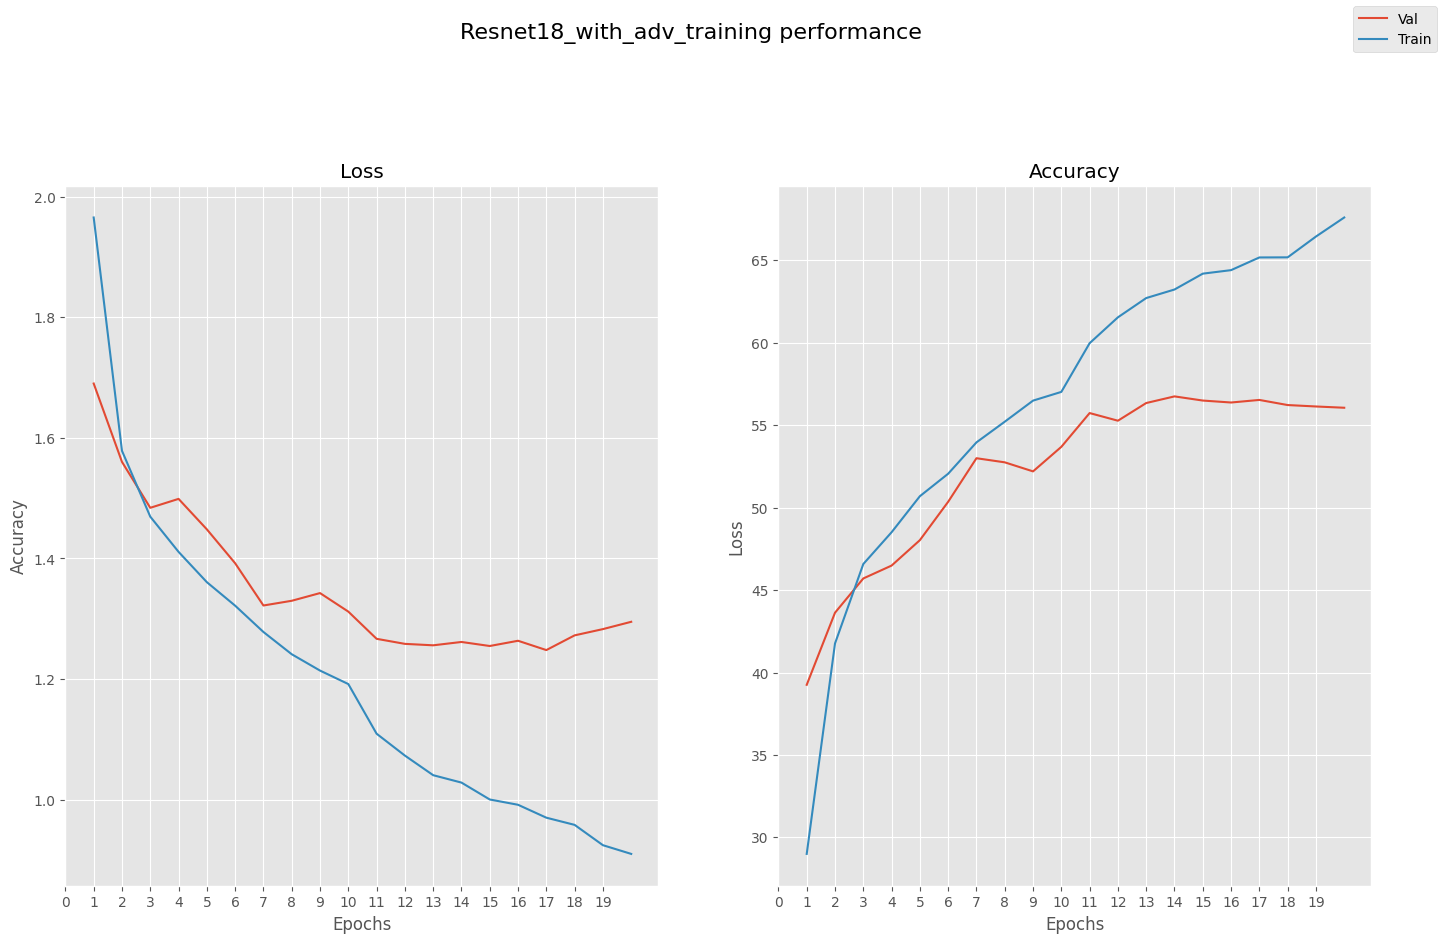

In [31]:
plot_performance(history,model_name)

In [32]:
adv_resnet_backbone=resnet_adv.Backbone()
resnet_adv.evaluate(test_loader,"test")
resnet_adv.evaluate(train_loader,"train")

Accuracy of the Resnet18_with_adv_training on the 10000 test images: 55 %
Accuracy of the Resnet18_with_adv_training on the 40000 train images: 67 %


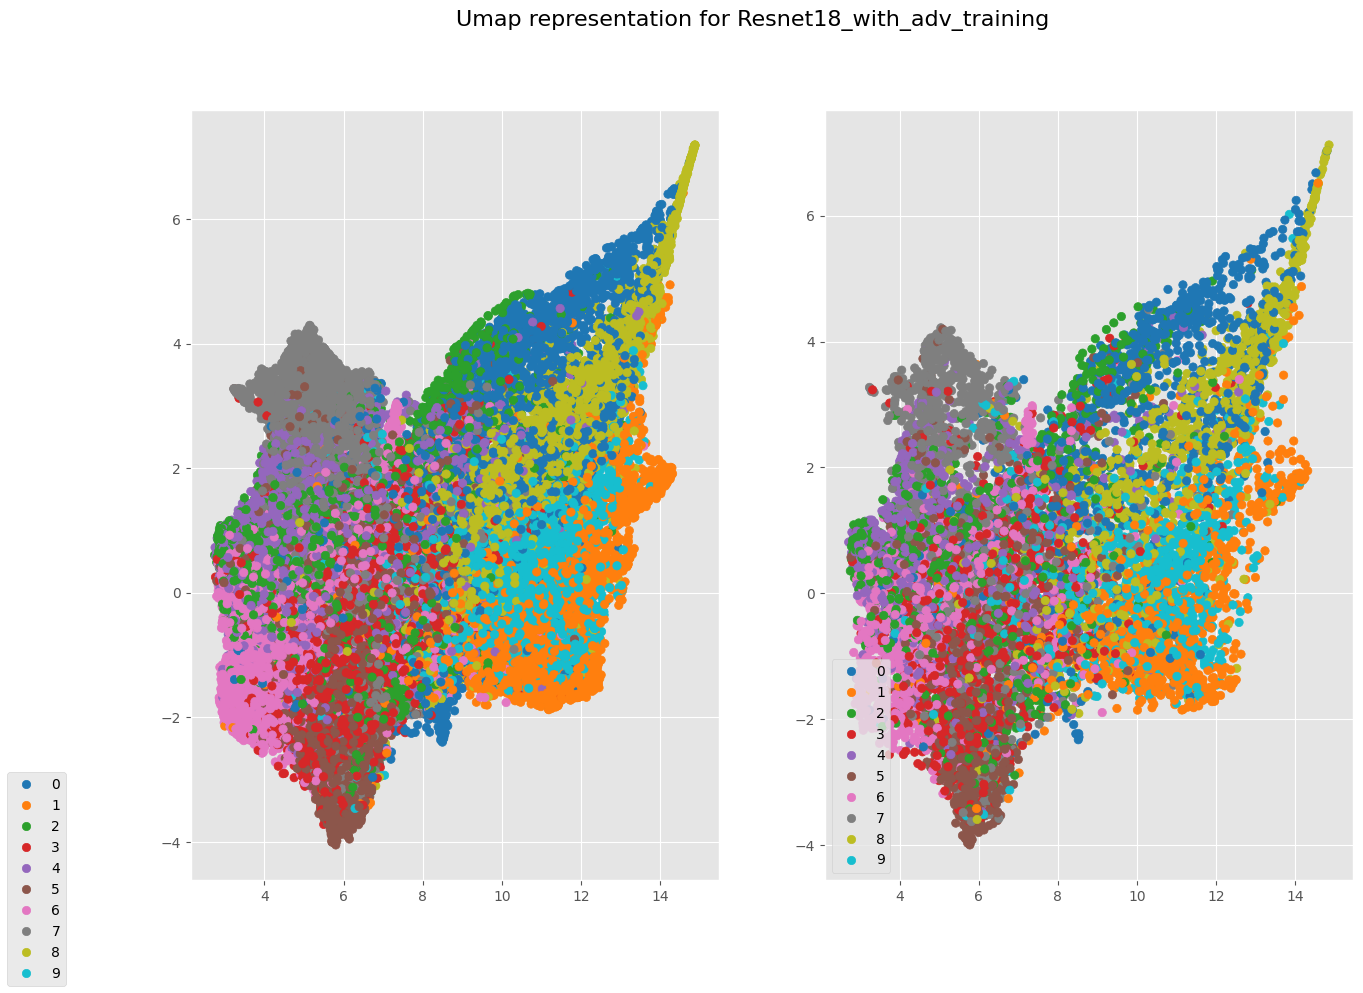

In [33]:
umap_rep=Umap_model(train_loader,test_loader,2)
umap_rep.fit_transform(resnet_adv)
umap_rep.plotter()

In [34]:
transform_clean = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233,0.24348505,0.26158768))
])
train_loader_clean,val_loader_clean,test_loader_clean=Dataloader(256,0.8,transform_clean,transform_clean)

Files already downloaded and verified
Files already downloaded and verified


In [35]:
adv_resnet_backbone=resnet_adv.Backbone()
resnet_adv.evaluate(train_loader_clean,"test")
resnet_adv.evaluate(test_loader_clean,"train")

Accuracy of the Resnet18_with_adv_training on the 40000 test images: 61 %
Accuracy of the Resnet18_with_adv_training on the 10000 train images: 50 %


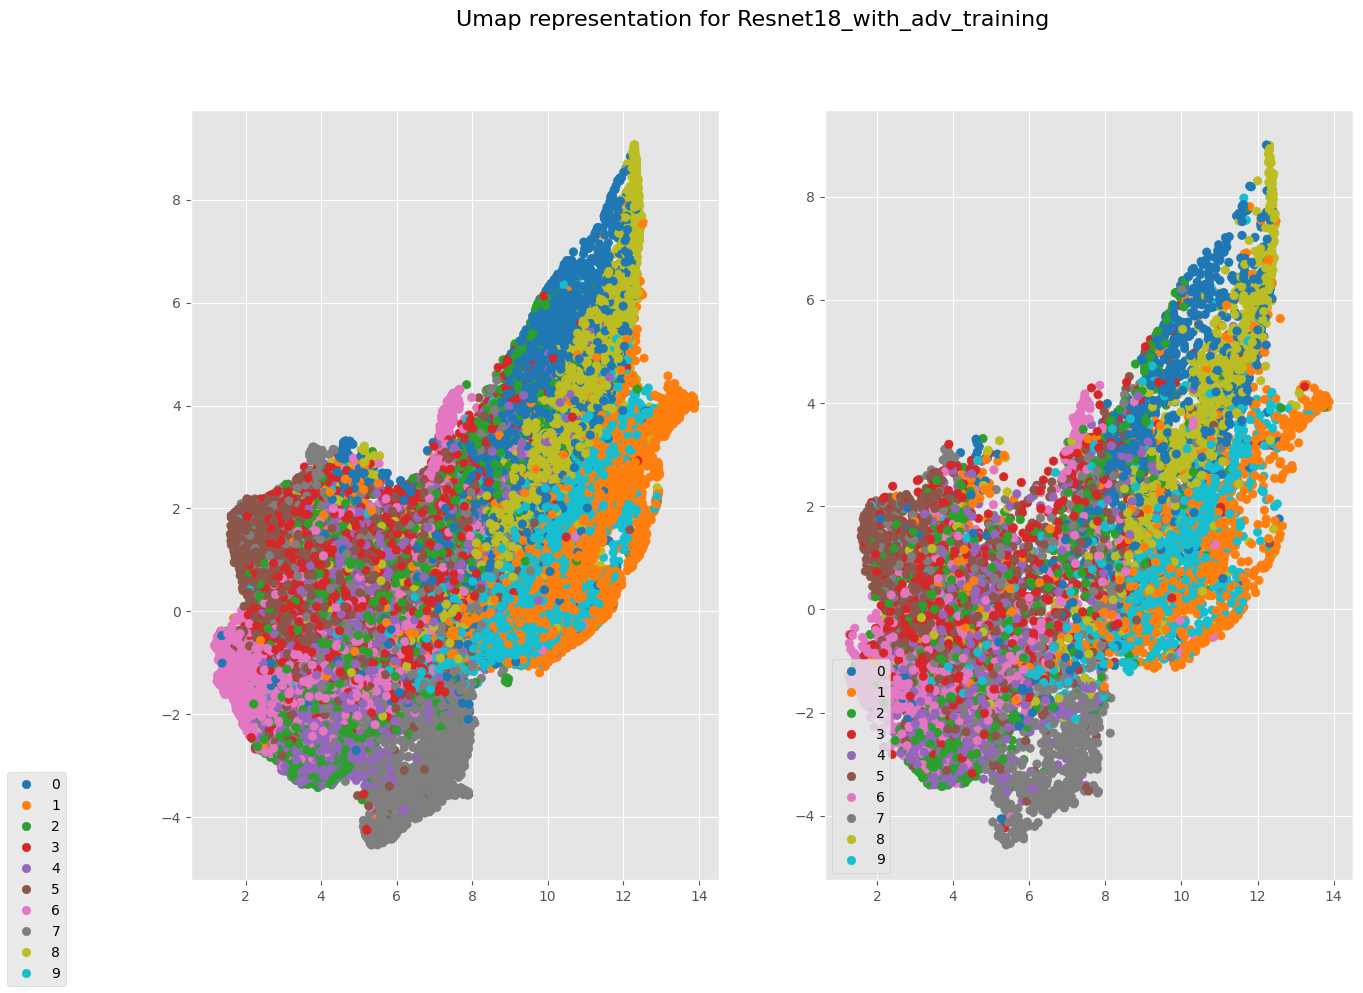

In [36]:
umap_rep=Umap_model(train_loader_clean,test_loader_clean,2)
umap_rep.fit_transform(resnet_adv)
umap_rep.plotter()

## FSGM

In [37]:
correct = 0
total = 0
adv_model.eval()
test_images_features=[]
clean_resnet18_backbone=clean_resnet18.Backbone()
for data in test_loader:
    images, labels = data
    images = images.to(device).float()
    labels = labels.to(device)
    # calculate outputs by running images through the network
    #torch.set_grad_enabled(True)
    images = fast_gradient_method(adv_model, images, 0.3, np.inf)
    im=adv_resnet_backbone(images)
    test_images_features.extend(im.squeeze().tolist())
    outputs = adv_model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
correct = 0
total = 0
train_images_features=[]
for data in train_loader:
    images, labels = data
    images = images.to(device).float()
    labels = labels.to(device)
    # calculate outputs by running images through the network
    #torch.set_grad_enabled(True)
    images = fast_gradient_method(adv_model, images, 0.3, np.inf)
    outputs = adv_model(images)
    im=adv_resnet_backbone(images)
    train_images_features.extend(im.squeeze().tolist())
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 40000 train images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 15 %
Accuracy of the network on the 40000 train images: 12 %


In [38]:
reducer = UMAP(n_components=2)
reducer.fit(train_images_features)
adv_train_features=reducer.transform(train_images_features)
adv_test_features=reducer.transform(test_images_features)

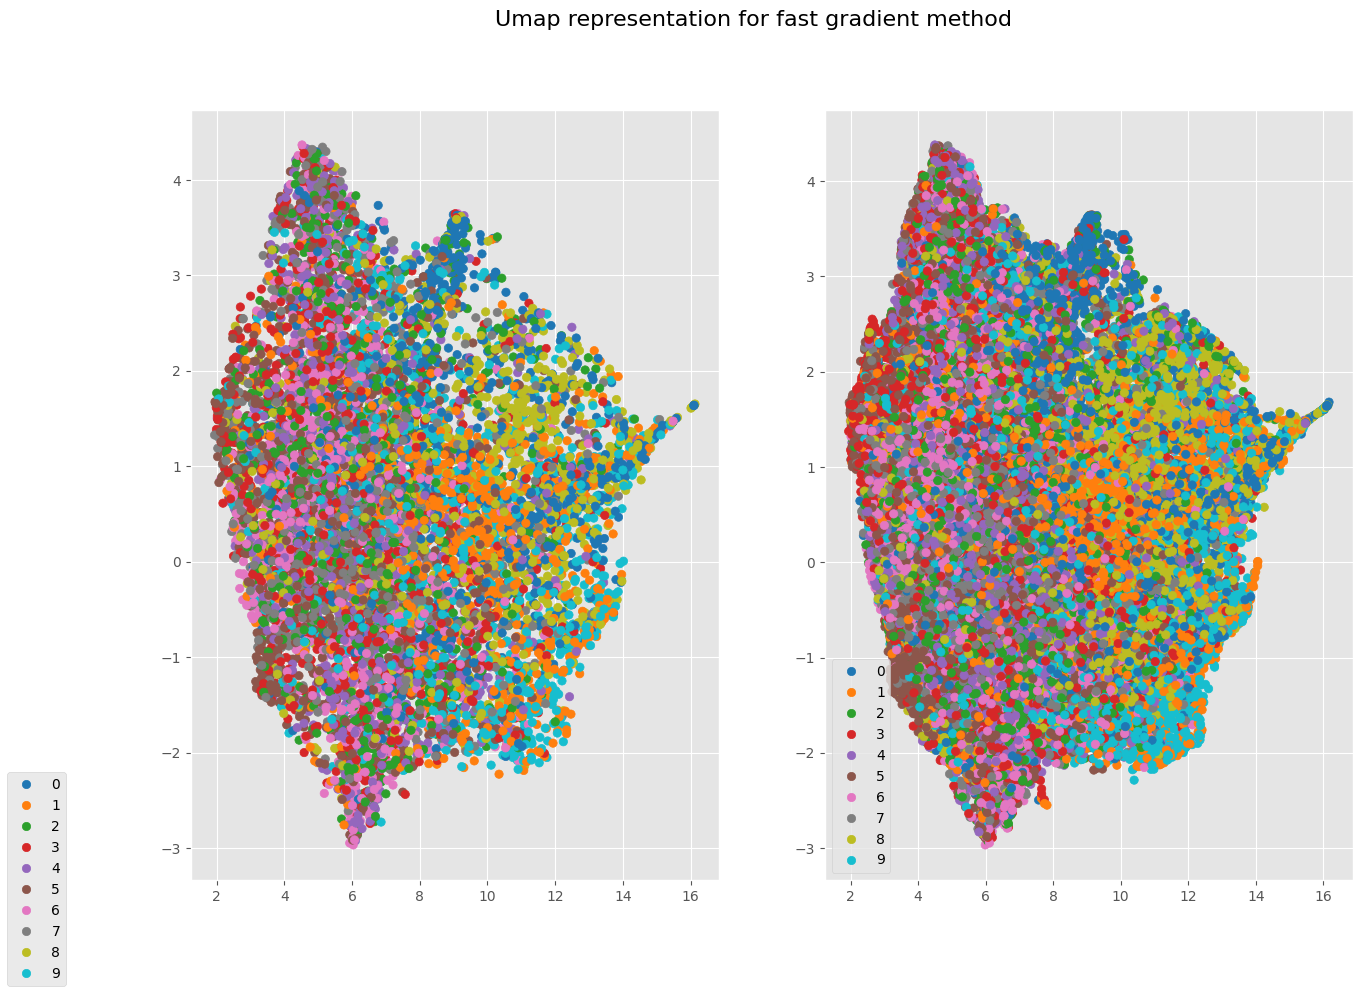

In [40]:
train_tags=labels_extract(train_loader)
test_tags=labels_extract(test_loader)
figure, axis = plt.subplots(1, 2,figsize=(15,10))
figure.suptitle('Umap representation for fast gradient method', fontsize=16)
scat=axis[0].scatter(adv_test_features[:,1],adv_test_features[:,0],c=test_tags,label=test_tags, cmap='tab10')
figure.legend(handles=scat.legend_elements()[0], loc="lower left",labels=[0,1,2,3,4,5,6,7,8,9])
scat=axis[1].scatter(adv_train_features[:,1],adv_train_features[:,0],c= train_tags,label= train_tags, cmap='tab10')
plt.legend(handles=scat.legend_elements()[0], loc="lower left",labels=[0,1,2,3,4,5,6,7,8,9])

# 6


In [ ]:
from pytorch_metric_learning.losses import AngularLoss

## resnet

In [42]:
class Resnet18_Angular_loss:
  def __init__(self,num_classes,gamma,step_size,model_name,loss=None):
    self.num_classes=num_classes
    self.gamma=gamma
    self.step_size=step_size
    self.model_name=model_name
    self.model = resnet18(pretrained=False)
    self.model.fc =  nn.Sequential( nn.Linear(self.model.fc.in_features, 128),nn.LayerNorm(128))
    self.model.to(device)
    # Define the loss function and optimizer
    self.criterion = loss
    self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
    self.lr_scheduler = StepLR(self.optimizer, step_size=self.step_size, gamma=self.gamma)
  def train(self,batch_size,epochs,learning_rate,ckpt_save_freq,report,ckpt_save_path,report_path,train_loader,val_loader):
    history={"val_acc":[],"train_acc":[],"val_loss":[],"train_loss":[],"epochs":[]}
    for epoch in tqdm(range(1, epochs + 1)):
        top1_acc_train = AverageMeter()
        loss_avg_train = AverageMeter()
        top1_acc_val = AverageMeter()
        loss_avg_val = AverageMeter()
        self.model.train()
        mode = "train"
        loop_train = tqdm(
            enumerate(train_loader, 1),
            total=len(train_loader),
            desc="train",
            position=0,
            leave=True)
        temp1=0
        temp2=0
        counter=0
        for batch_idx, (images, labels) in loop_train:
            images = images.to(device)
            labels = labels.to(device)
            labels_pred = self.model(images)
            loss = self.criterion(labels_pred, labels)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            acc1 = accuracy(labels_pred, labels)
            top1_acc_train.update(acc1[0], images.size(0))
            loss_avg_train.update(loss.item(), images.size(0))
            counter=counter+1
            temp1=temp1+loss_avg_train.avg
            temp2=temp2+top1_acc_train.avg
            new_row = pd.DataFrame(
                {"model_name": self.model_name,
                  "mode": mode,
                  "image_type":"original",
                  "epoch": epoch,
                  "learning_rate":self.optimizer.param_groups[0]["lr"],
                  "batch_size": images.size(0),
                  "batch_index": batch_idx,
                  "loss_batch": loss.detach().item(),
                  "avg_train_loss_till_current_batch":loss_avg_train.avg,
                  "avg_train_top1_acc_till_current_batch":top1_acc_train.avg,
                  "avg_val_loss_till_current_batch":None,
                  "avg_val_top1_acc_till_current_batch":None},index=[0])

            
            report.loc[len(report)] = new_row.values[0]
            
            loop_train.set_description(f"Train - iteration : {epoch}")
            loop_train.set_postfix(
                loss_batch="{:.4f}".format(loss.detach().item()),
                avg_train_loss_till_current_batch="{:.4f}".format(loss_avg_train.avg),
                top1_accuracy_train="{:.4f}".format(top1_acc_train.avg),
                max_len=2,
                refresh=True,
            )
        if epoch % ckpt_save_freq == 0:
            save_model(
                file_path=ckpt_save_path,
                file_name=f"ckpt_{self.model_name}_epoch{epoch}.ckpt",
                model=self.model,
                optimizer=self.optimizer,
            )
        history["train_loss"].append(temp1/counter)
        history["train_acc"].append(temp2/counter)
        self.model.eval()
        mode = "val"
        with torch.no_grad():
            loop_val = tqdm(
                enumerate(val_loader, 1),
                total=len(val_loader),
                desc="val",
                position=0,
                leave=True,
            )
            temp1=0
            temp2=0
            counter=0
            for batch_idx, (images, labels) in loop_val:
                self.optimizer.zero_grad()
                images = images.to(device).float()
                labels = labels.to(device)
                labels_pred = self.model(images)
                loss = self.criterion(labels_pred, labels)
                acc1 = accuracy(labels_pred, labels)
                top1_acc_val.update(acc1[0], images.size(0))
                loss_avg_val.update(loss.item(), images.size(0))
                temp1=loss_avg_val.avg+temp1
                temp2=top1_acc_val.avg+temp2
                counter=counter+1
                new_row = pd.DataFrame(
                    {"model_name": self.model_name,
                      "mode": mode,
                      "image_type":"original",
                      "epoch": epoch,
                      "learning_rate":self.optimizer.param_groups[0]["lr"],
                      "batch_size": images.size(0),
                      "batch_index": batch_idx,
                      "loss_batch": loss.detach().item(),
                      "avg_train_loss_till_current_batch":None,
                      "avg_train_top1_acc_till_current_batch":None,
                      "avg_val_loss_till_current_batch":loss_avg_val.avg,
                      "avg_val_top1_acc_till_current_batch":top1_acc_val.avg},index=[0],)
                
                report.loc[len(report)] = new_row.values[0]
                loop_val.set_description(f"val - iteration : {epoch}")
                loop_val.set_postfix(
                    loss_batch="{:.4f}".format(loss.detach().item()),
                    avg_val_loss_till_current_batch="{:.4f}".format(loss_avg_val.avg),
                    top1_accuracy_val="{:.4f}".format(top1_acc_val.avg),
                    refresh=True,
                )
        history["val_loss"].append(temp1/counter)
        history["val_acc"].append(temp2/counter)
        history["epochs"].append(epoch)
        self.lr_scheduler.step()
    report.to_csv(f"{report_path}/{self.model_name}_report.csv")
    return self.model,history
  def Backbone(self):
    self.backbone = nn.Sequential(*list(self.model.children())[:-1])
    classifier = nn.Sequential(self.model.fc)
    return self.backbone
  def evaluate(self,testloader,datatype="test"):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    self.model.eval()
    self.backbone.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device).float()
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = self.model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the {self.model_name} on the {total} {datatype} images: {100 * correct // total} %')
  def feature_extractor(self,testloader):
    features=[]
    self.model.eval()
    self.backbone.eval()
    for (images, labels) in testloader:
            images = images.to(device)
            labels = labels.to(device)
            labels_pred = self.backbone(images)
            features.extend(labels_pred.squeeze().tolist())
  def angular_feature_extractor(self,testloader):
    features=[]
    self.model.eval()
    for (images, labels) in testloader:
            images = images.to(device)
            labels = labels.to(device)
            labels_pred = self.model(images)
            features.extend(labels_pred.squeeze().tolist())
    return features

## 6.2

In [43]:
# Load the CIFAR10 dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233,0.24348505,0.26158768))
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader,val_loader,test_loader=Dataloader(256,0.8,transform,transform)

Files already downloaded and verified
Files already downloaded and verified


In [44]:

num_classes = 10
step_size=10
gamma=0.5
model_name="Angular_Resnet18_without_adv"
loss=AngularLoss()
resnet=Resnet18_Angular_loss(num_classes,gamma,step_size,model_name,loss)

batch_size = 64
epochs = 20
learning_rate = 1e-3
ckpt_save_freq = 10

report = pd.DataFrame(columns=["model_name","mode","image_type","epoch","learning_rate","batch_size",
                               "batch_index","loss_batch","avg_train_loss_till_current_batch","avg_train_top1_acc_till_current_batch",
                               "avg_val_loss_till_current_batch","avg_val_top1_acc_till_current_batch"])
ckpt_save_path="./"
report_path="./"

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [45]:
model,history=resnet.train(batch_size,epochs,learning_rate,ckpt_save_freq,report,ckpt_save_path,report_path,train_loader,val_loader)

100%|██████████| 20/20 [06:36<00:00, 19.85s/it]


In [46]:
test_features=resnet.angular_feature_extractor(test_loader)
train_features=resnet.angular_feature_extractor(train_loader)

In [47]:
train_labels= labels_extract(train_loader)
test_labels= labels_extract(test_loader)

In [50]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_features, train_labels)

KNeighborsClassifier(n_neighbors=3)

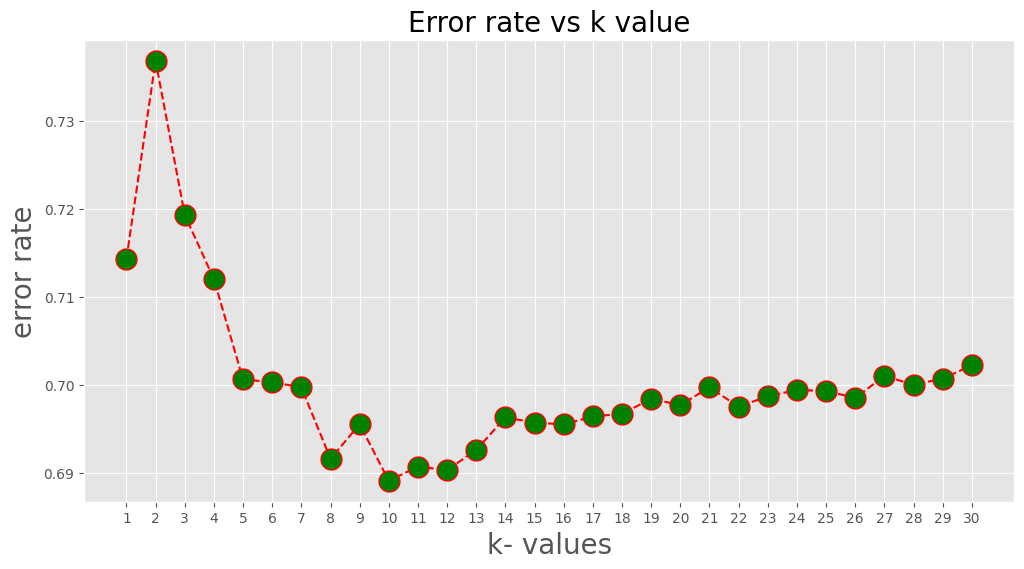

In [55]:
error_rate=[]
for i in range (1,31):  #Took the range of k from 1 to 30
    clf=KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_features,train_labels)
    predict_i=clf.predict(test_features)
    error_rate.append(np.mean(predict_i!=test_labels))
plt.figure(figsize=(12,6))
plt.plot(range(1,31),error_rate,marker="o",markerfacecolor="green",
         linestyle="dashed",color="red",markersize=15)
plt.title("Error rate vs k value",fontsize=20)
plt.xlabel("k- values",fontsize=20)
plt.ylabel("error rate",fontsize=20)
plt.xticks(range(1,31))
plt.show()

In [57]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(train_features, train_labels)

KNeighborsClassifier(n_neighbors=10)

In [58]:
from sklearn.metrics import classification_report
print(classification_report(neigh.predict(train_features), train_labels))

              precision    recall  f1-score   support

           0       0.62      0.39      0.48      6373
           1       0.37      0.56      0.45      2647
           2       0.48      0.35      0.40      5525
           3       0.28      0.47      0.35      2364
           4       0.53      0.36      0.43      5881
           5       0.28      0.57      0.38      1993
           6       0.54      0.40      0.46      5320
           7       0.32      0.56      0.41      2269
           8       0.57      0.44      0.49      5283
           9       0.33      0.56      0.41      2345

    accuracy                           0.43     40000
   macro avg       0.43      0.47      0.43     40000
weighted avg       0.48      0.43      0.44     40000



In [59]:
from sklearn.metrics import classification_report
print(classification_report(neigh.predict(test_features), test_labels))

              precision    recall  f1-score   support

           0       0.49      0.29      0.36      1689
           1       0.26      0.42      0.32       623
           2       0.35      0.24      0.29      1446
           3       0.14      0.27      0.18       509
           4       0.41      0.28      0.33      1471
           5       0.17      0.42      0.24       415
           6       0.43      0.30      0.35      1438
           7       0.18      0.38      0.24       482
           8       0.46      0.33      0.38      1387
           9       0.22      0.41      0.29       540

    accuracy                           0.31     10000
   macro avg       0.31      0.33      0.30     10000
weighted avg       0.37      0.31      0.32     10000



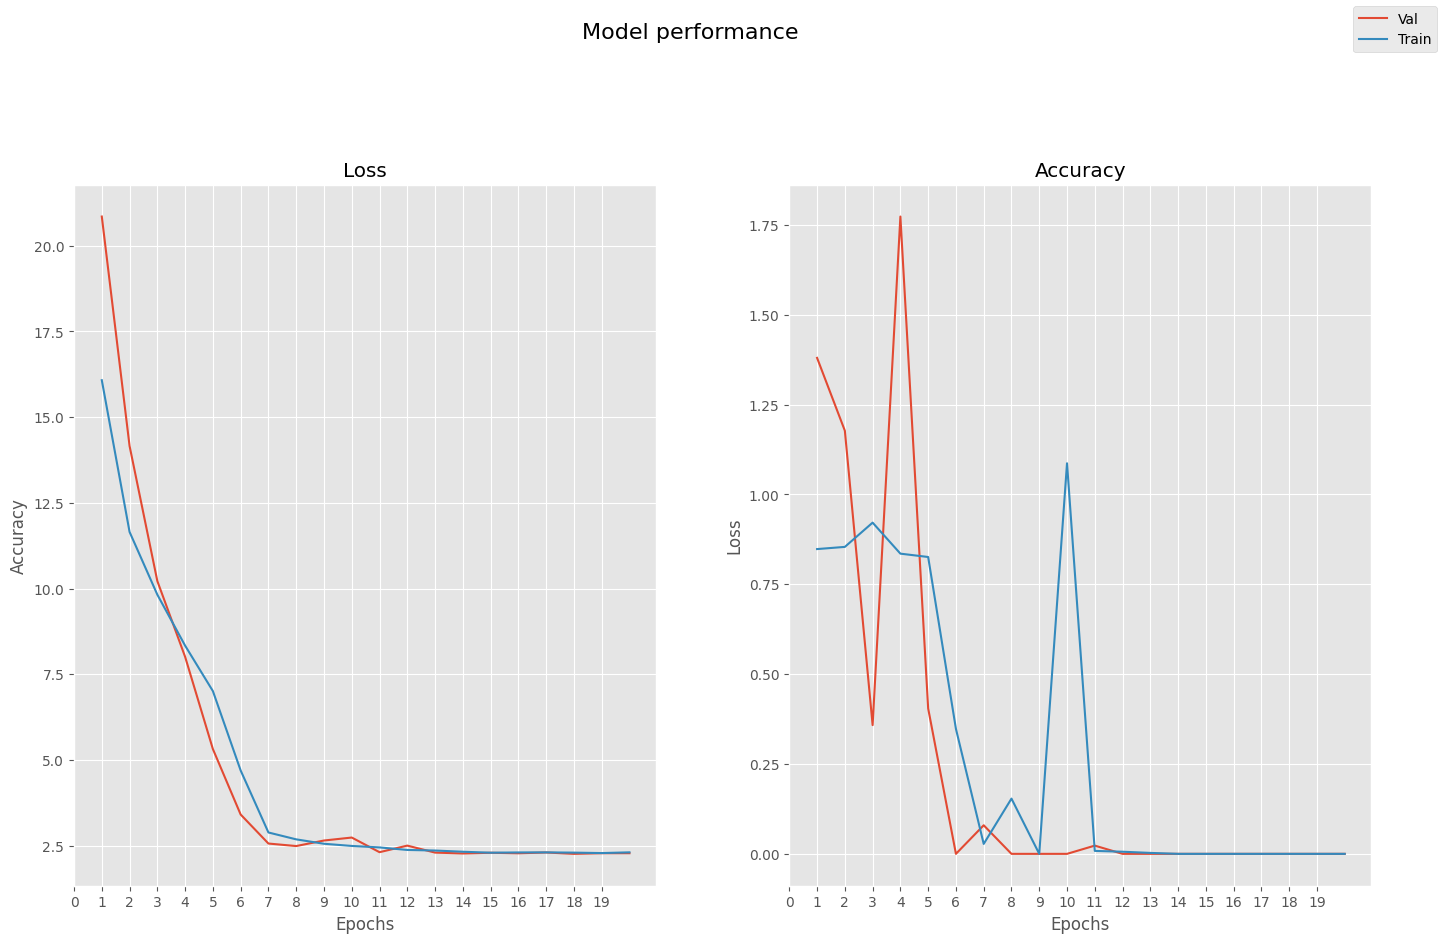

In [60]:
plot_performance(history)

In [62]:
test_features=resnet.angular_feature_extractor(test_loader)
train_features=resnet.angular_feature_extractor(train_loader)
reducer = UMAP(n_components=2)
reducer.fit(train_features)
adv_train_features=reducer.transform(train_features)
adv_test_features=reducer.transform(test_features)

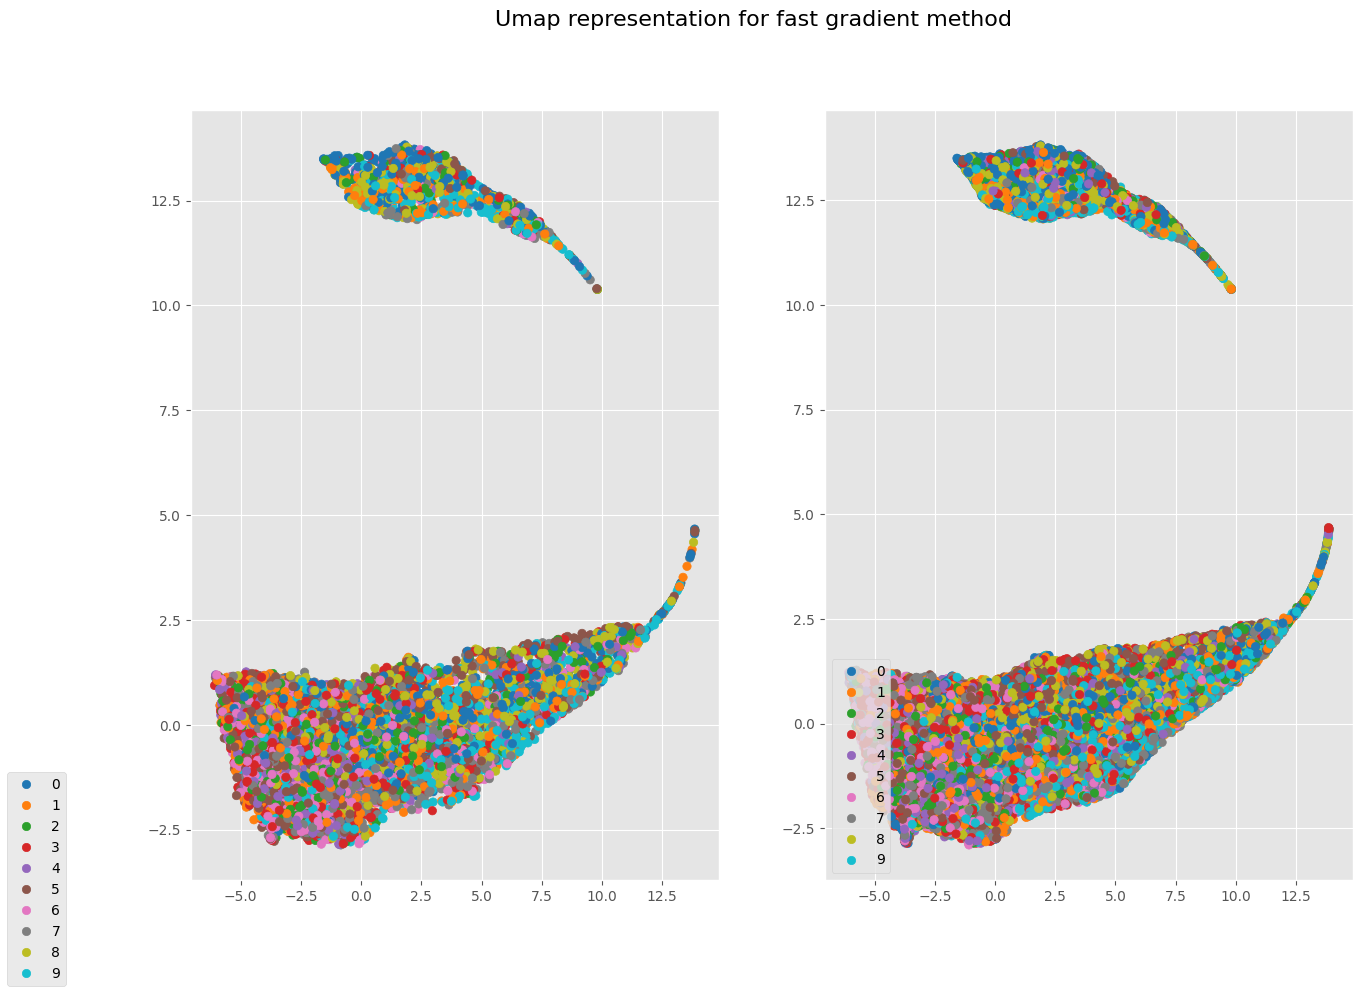

In [63]:
train_tags=labels_extract(train_loader)
test_tags=labels_extract(test_loader)
figure, axis = plt.subplots(1, 2,figsize=(15,10))
figure.suptitle('Umap representation for fast gradient method', fontsize=16)
scat=axis[0].scatter(adv_test_features[:,1],adv_test_features[:,0],c=test_tags,label=test_tags, cmap='tab10')
figure.legend(handles=scat.legend_elements()[0], loc="lower left",labels=[0,1,2,3,4,5,6,7,8,9])
scat=axis[1].scatter(adv_train_features[:,1],adv_train_features[:,0],c= train_tags,label= train_tags, cmap='tab10')
plt.legend(handles=scat.legend_elements()[0], loc="lower left",labels=[0,1,2,3,4,5,6,7,8,9])

# 6.3

In [68]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233,0.24348505,0.26158768)),
    torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
    AddGaussianNoise(0., 1.),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.RandomHorizontalFlip(p=0.1)
])
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233,0.24348505,0.26158768))
])
train_loader,val_loader,test_loader=Dataloader(256,0.2,transform,test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [70]:
from sklearn.metrics import classification_report
test_features=resnet.angular_feature_extractor(test_loader)
train_features=resnet.angular_feature_extractor(train_loader)
train_tags=labels_extract(train_loader)
test_tags=labels_extract(test_loader)
print(classification_report(neigh.predict(train_features), train_tags))

              precision    recall  f1-score   support

           0       0.61      0.39      0.47      1608
           1       0.38      0.58      0.46       661
           2       0.46      0.34      0.39      1348
           3       0.30      0.51      0.37       587
           4       0.54      0.36      0.43      1452
           5       0.29      0.59      0.39       487
           6       0.55      0.41      0.47      1335
           7       0.31      0.57      0.40       532
           8       0.60      0.44      0.51      1401
           9       0.31      0.54      0.39       589

    accuracy                           0.43     10000
   macro avg       0.43      0.47      0.43     10000
weighted avg       0.49      0.43      0.44     10000



In [71]:
from sklearn.metrics import classification_report
print(classification_report(neigh.predict(test_features), test_tags))

              precision    recall  f1-score   support

           0       0.50      0.27      0.35      1826
           1       0.21      0.31      0.25       675
           2       0.23      0.20      0.21      1172
           3       0.14      0.21      0.16       651
           4       0.27      0.22      0.24      1227
           5       0.18      0.35      0.24       515
           6       0.42      0.27      0.33      1558
           7       0.20      0.34      0.25       575
           8       0.38      0.30      0.33      1248
           9       0.21      0.38      0.27       553

    accuracy                           0.27     10000
   macro avg       0.27      0.29      0.26     10000
weighted avg       0.32      0.27      0.28     10000



In [73]:
correct = 0
total = 0
model.eval()
test_images_features=[]
angular_resnet18_backbone=resnet.Backbone()
for data in test_loader:
    images, labels = data
    images = images.to(device).float()
    labels = labels.to(device)
    # calculate outputs by running images through the network
    #torch.set_grad_enabled(True)
    images = fast_gradient_method(model, images, 0.3, np.inf)
    outputs = model(images)
    test_images_features.extend(outputs.squeeze().tolist())
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
correct = 0
total = 0
train_images_features=[]
for data in train_loader:
    images, labels = data
    images = images.to(device).float()
    labels = labels.to(device)
    # calculate outputs by running images through the network
    #torch.set_grad_enabled(True)
    images = fast_gradient_method(model, images, 0.3, np.inf)
    outputs = model(images)
    train_images_features.extend(outputs.squeeze().tolist())
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 40000 train images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 0 %
Accuracy of the network on the 40000 train images: 0 %


In [74]:
from sklearn.metrics import classification_report
print(classification_report(neigh.predict(train_images_features), train_tags))

              precision    recall  f1-score   support

           0       0.45      0.36      0.40      1284
           1       0.19      0.41      0.26       473
           2       0.40      0.28      0.33      1422
           3       0.24      0.35      0.28       688
           4       0.54      0.26      0.35      2034
           5       0.23      0.46      0.31       483
           6       0.50      0.33      0.40      1519
           7       0.32      0.42      0.37       749
           8       0.35      0.40      0.38       892
           9       0.19      0.43      0.27       456

    accuracy                           0.34     10000
   macro avg       0.34      0.37      0.33     10000
weighted avg       0.40      0.34      0.35     10000



In [75]:
from sklearn.metrics import classification_report
print(classification_report(neigh.predict(test_images_features), test_tags))

              precision    recall  f1-score   support

           0       0.40      0.30      0.34      1322
           1       0.15      0.26      0.19       557
           2       0.22      0.16      0.19      1332
           3       0.16      0.20      0.18       799
           4       0.30      0.18      0.23      1631
           5       0.17      0.27      0.21       633
           6       0.36      0.22      0.27      1664
           7       0.22      0.24      0.23       906
           8       0.27      0.36      0.31       761
           9       0.15      0.38      0.21       395

    accuracy                           0.24     10000
   macro avg       0.24      0.26      0.24     10000
weighted avg       0.27      0.24      0.24     10000



In [76]:
reducer = UMAP(n_components=2)
reducer.fit(train_images_features)
adv_train_features=reducer.transform(train_images_features)
adv_test_features=reducer.transform(test_images_features)

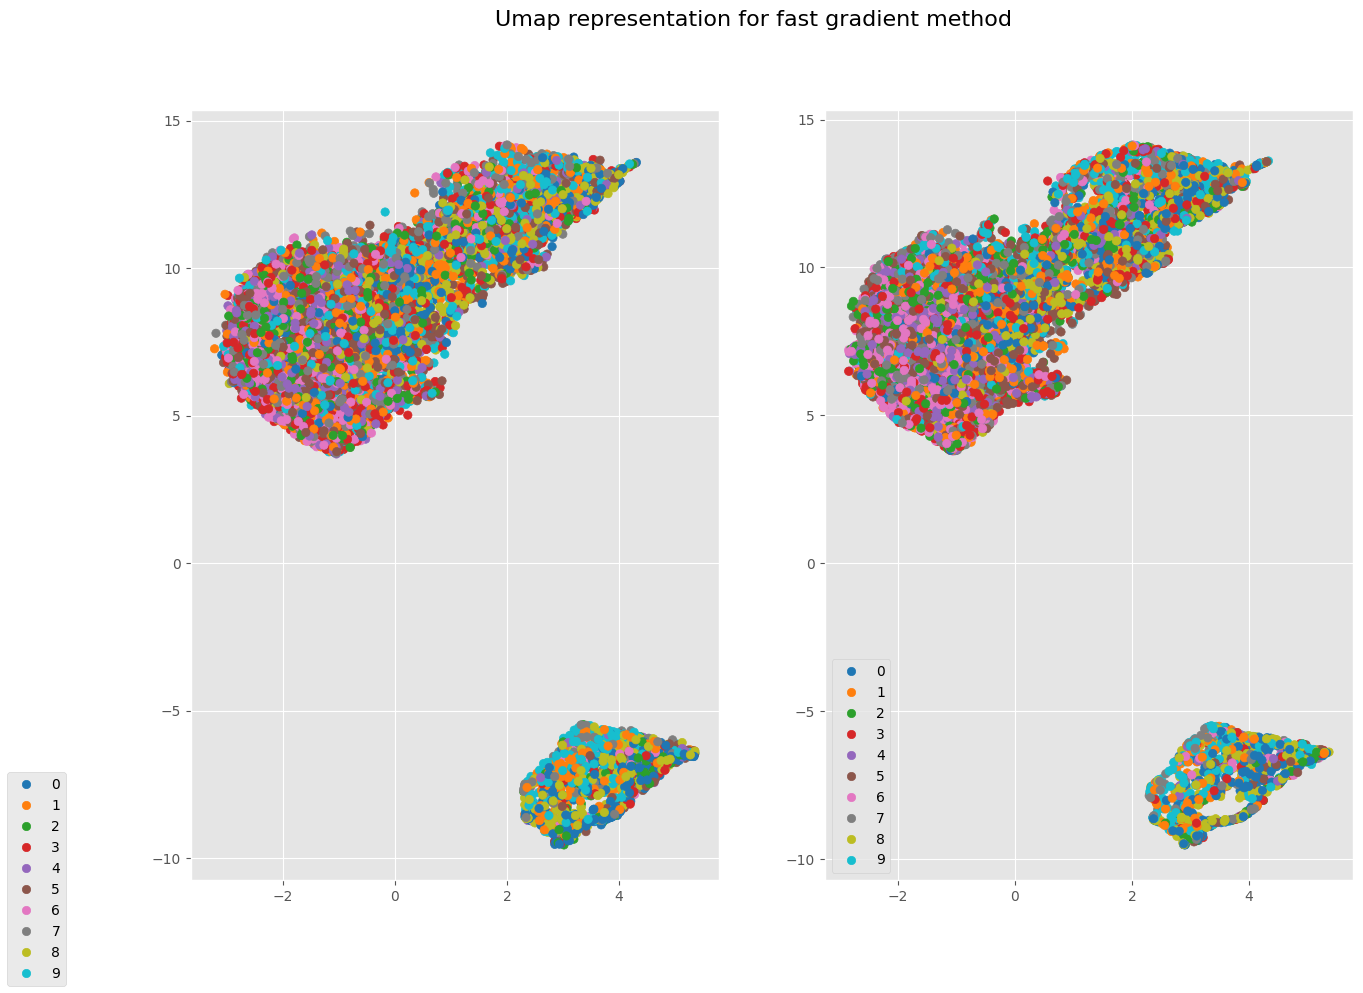

In [77]:
train_tags=labels_extract(train_loader)
test_tags=labels_extract(test_loader)
figure, axis = plt.subplots(1, 2,figsize=(15,10))
figure.suptitle('Umap representation for fast gradient method', fontsize=16)
scat=axis[0].scatter(adv_test_features[:,1],adv_test_features[:,0],c=test_tags,label=test_tags, cmap='tab10')
figure.legend(handles=scat.legend_elements()[0], loc="lower left",labels=[0,1,2,3,4,5,6,7,8,9])
scat=axis[1].scatter(adv_train_features[:,1],adv_train_features[:,0],c= train_tags,label= train_tags, cmap='tab10')
plt.legend(handles=scat.legend_elements()[0], loc="lower left",labels=[0,1,2,3,4,5,6,7,8,9])